In [115]:
%load_ext autoreload
%autoreload 2
%pylab inline

import numpy as np
from arnie.pfunc import pfunc
from arnie.bpps import bpps
from arnie.sample_structures import sample_structures
import arnie.utils as utils
from decimal import Decimal
from arnie.free_energy import free_energy

import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
mpl.rcParams['figure.dpi']= 300


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/Users/hwayment/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [149]:
hhr = "ACGCUGUCUGUACUUGUAUCAGUACACUGACGAGUCCCUAAAGGACGAAACAGCGC"
n_samples=500

struct_list, _ , _ = sample_structures(hhr, n_samples=n_samples, package='vienna_2')

vienna_energy_list = [free_energy(hhr, structure=s.replace('.','x'), package='vienna_2')[0] for s in struct_list]
# Not used in the reweighting, but including them here to compare to the contrafold energies

contrafold_energy_list = [free_energy(hhr, structure=s.replace('.','x'), package='contrafold')[0] for s in struct_list]

In [133]:
#to save:

with open('hhr_struct_list.txt','w') as f:
    for i in range(n_samples):
        f.write("%s\t%.d%.d\n" % (struct_list[i],vienna_energy_list[i],contrafold_energy_list[i]))

Our coordinates in consideration are the posterior probabilities of each base being paired or unpaired. We histogram these in our reference system (Vienna) to get $p_{old}$. Then for each base, we weight by the scaled Boltzmann factor as estimated with Contrafold.

$p_{new} = p_{old} \dfrac{\langle \exp (-\beta dG)\rangle_j}{\sum \langle \exp (-\beta dG)\rangle_j}$

In [150]:
count_unpaired = {'.':1, '(':0, ')':0}

beta=1/0.6
boltzmann_weights=[]
ref_paired_distn, reweighted_paired_distn = np.zeros([len(hhr)]), np.zeros([len(hhr)])

for i, struct in enumerate(struct_list):
    
    p_vienna = np.array([count_unpaired[char] for char in struct]) 
    ref_paired_distn += p_vienna #increment for histogram
    
    contrafold_reweight = np.exp(-beta*(contrafold_energy_list[i]))/np.mean(np.exp(-beta*(np.array(contrafold_energy_list))))
    boltzmann_weights.append(contrafold_reweight)
    reweighted_paired_distn += p_vienna*contrafold_reweight

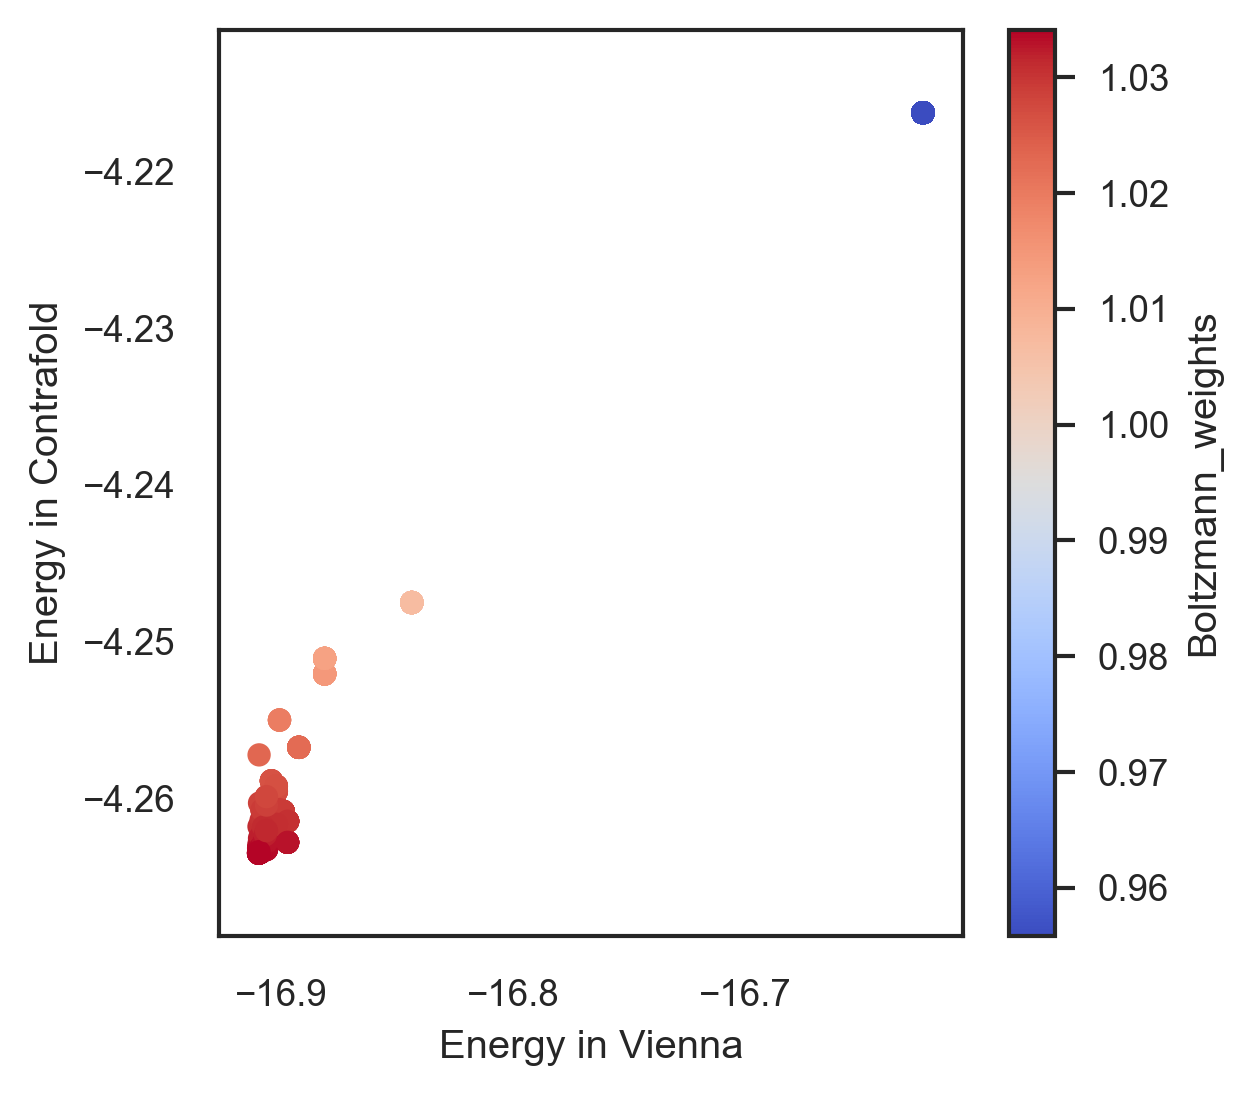

In [151]:
figure(figsize=(4,4))
scatter(vienna_energy_list,contrafold_energy_list, c=boltzmann_weights, cmap='coolwarm')
xlabel('Energy in Vienna')
ylabel('Energy in Contrafold')
colorbar(label='Boltzmann_weights')

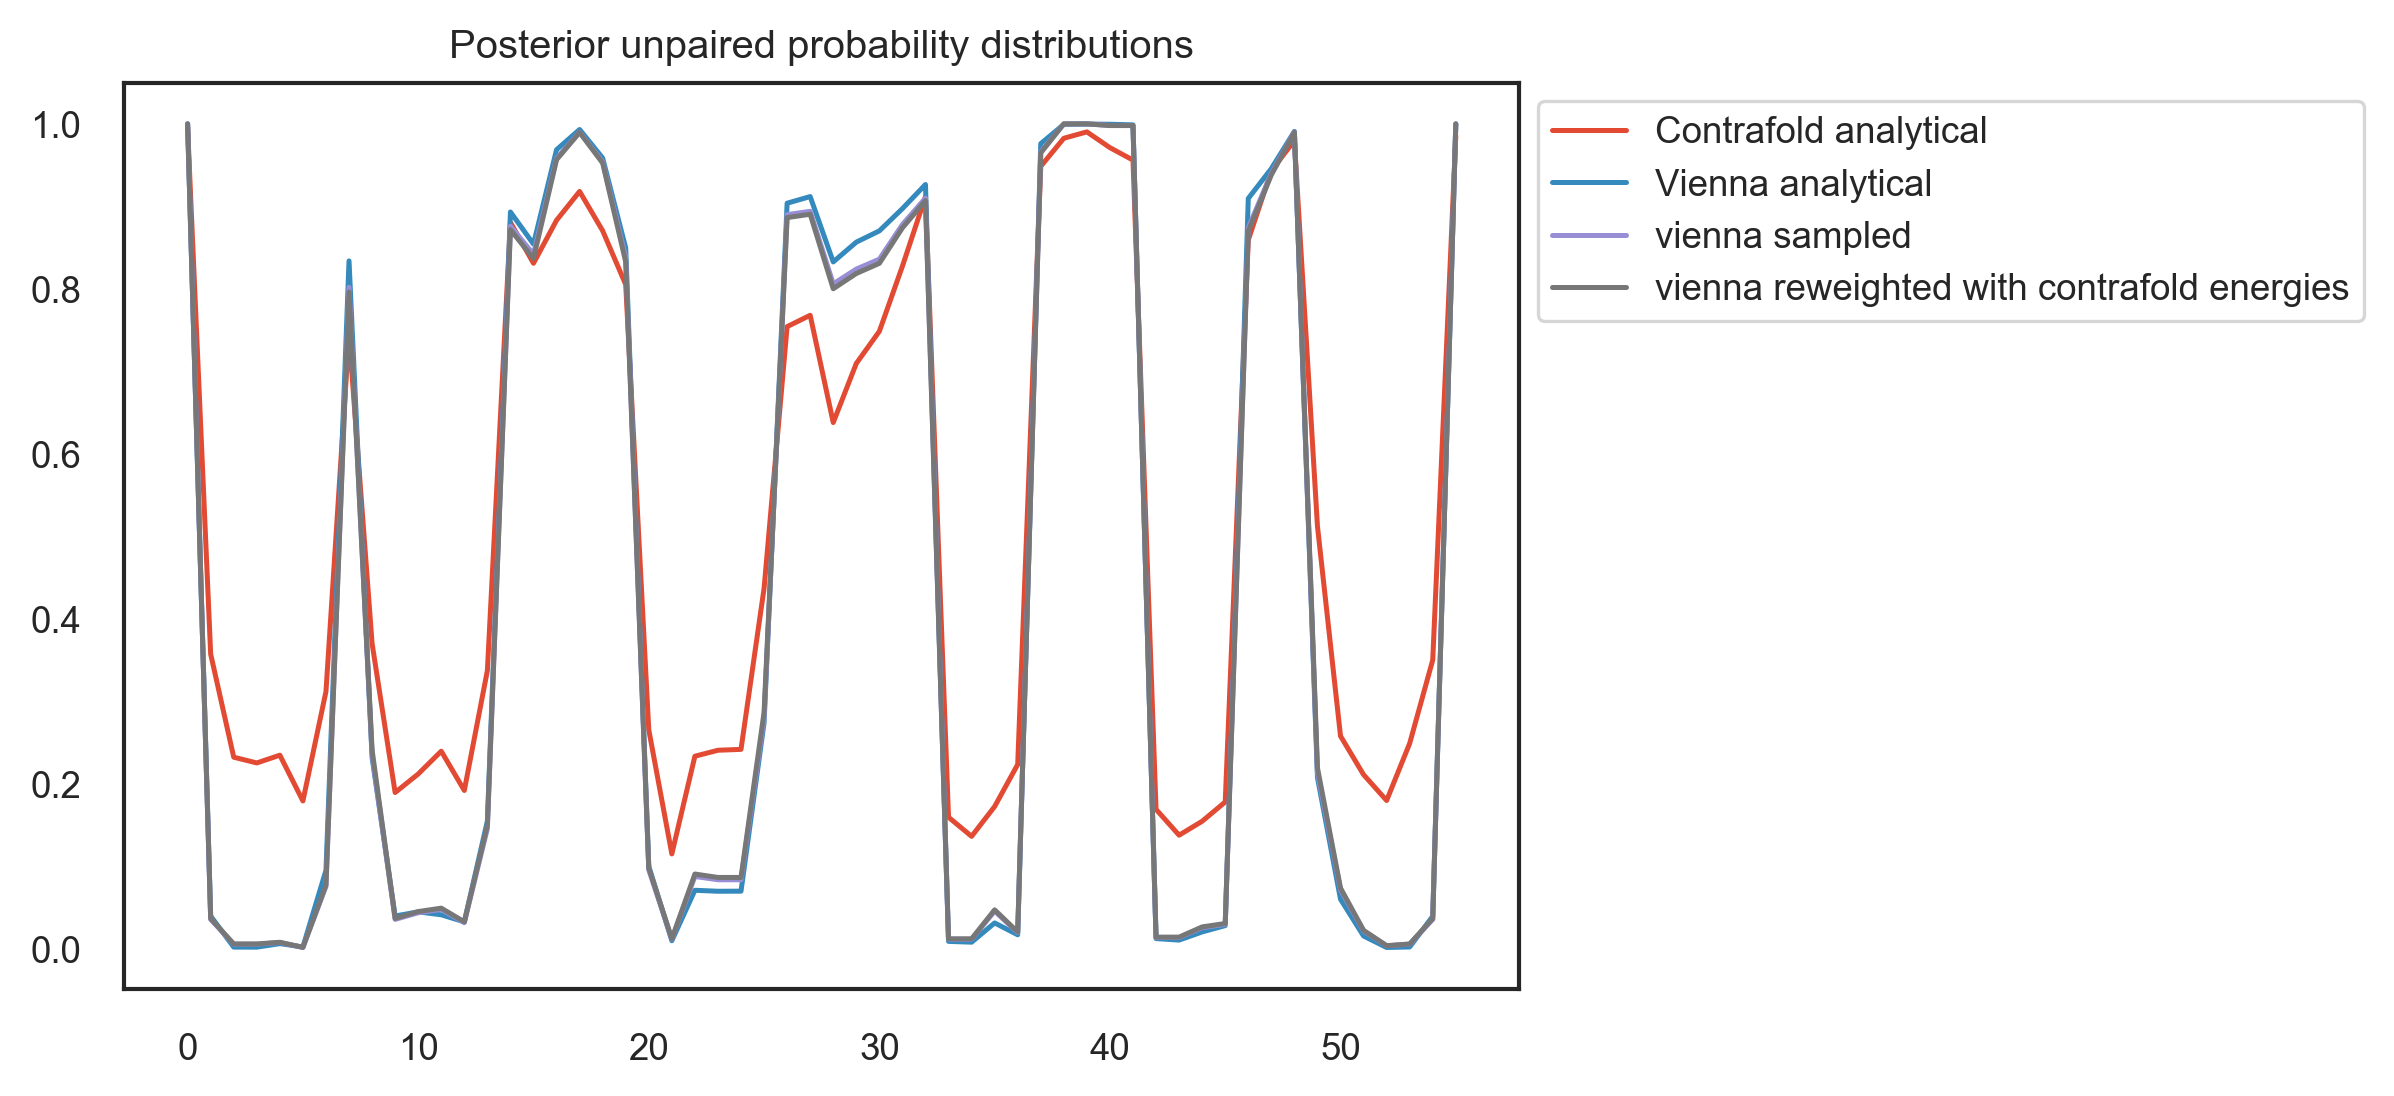

In [152]:
from arnie.bpps import bpps

cfold_bp_matrix = bpps(hhr,package='contrafold')
vienna_bp_matrix = bpps(hhr,package='vienna_2')

title('Posterior unpaired probability distributions')
plot(1-np.sum(cfold_bp_matrix,axis=0),label='Contrafold analytical')
plot(1-np.sum(vienna_bp_matrix,axis=0),label='Vienna analytical')

plot(ref_paired_distn/n_samples,label='vienna sampled')
plot(reweighted_paired_distn/n_samples,label='vienna reweighted with contrafold energies')

legend(bbox_to_anchor=(1,1))
#plot(reweighted_paired_distn/1000)